In [1]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    print(gpu)


2025-04-16 16:12:43.269950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744819963.794492      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744819963.936363      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [2]:
# Prevents GPU memory hogging
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Check GPU usage
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


In [4]:
base_dir = '/kaggle/input/swedish-leaf-dataset/Swedish'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['Leaf 4', 'Leaf 6', 'Leaf 11', 'Leaf 5', 'Leaf 7', 'Leaf 0', 'Leaf 9', 'Leaf 1', 'Leaf 13', 'Leaf 10', 'Leaf 12', 'Leaf 8', 'Leaf 14', 'Leaf 2', 'Leaf 3']
Test classes: ['Leaf 4', 'Leaf 6', 'Leaf 11', 'Leaf 5', 'Leaf 7', 'Leaf 0', 'Leaf 9', 'Leaf 1', 'Leaf 13', 'Leaf 10', 'Leaf 12', 'Leaf 8', 'Leaf 14', 'Leaf 2', 'Leaf 3']


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)


Found 1125 images belonging to 15 classes.
Found 285 images belonging to 15 classes.


In [6]:
from tensorflow.keras import layers, models

def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model


In [7]:
# Automatically utilizes all available GPUs
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_cnn_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


I0000 00:00:1744819986.198776      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744819986.199478      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1744820033.771193     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744820033.771209     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.0859 - loss: 3.4843 - val_accuracy: 0.2168 - val_loss: 2.2554
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 619ms/step - accuracy: 0.2445 - loss: 2.1989 - val_accuracy: 0.5175 - val_loss: 1.3799
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 648ms/step - accuracy: 0.3994 - loss: 1.7622 - val_accuracy: 0.6573 - val_loss: 1.0950
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 661ms/step - accuracy: 0.4716 - loss: 1.5656 - val_accuracy: 0.6573 - val_loss: 0.9772
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 602ms/step - accuracy: 0.5169 - loss: 1.3924 - val_accuracy: 0.6364 - val_loss: 0.9804
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.5597 - loss: 1.2757 - val_accuracy: 0.5455 - val_loss: 1.0618
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 611ms/step - accuracy: 0.5662 - loss: 1.2531 - val_accuracy: 0.7552 - val_loss: 0.6423
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 577ms/step - accuracy: 0.6154 - loss: 1.0880 - val_accuracy: 0.7832 -

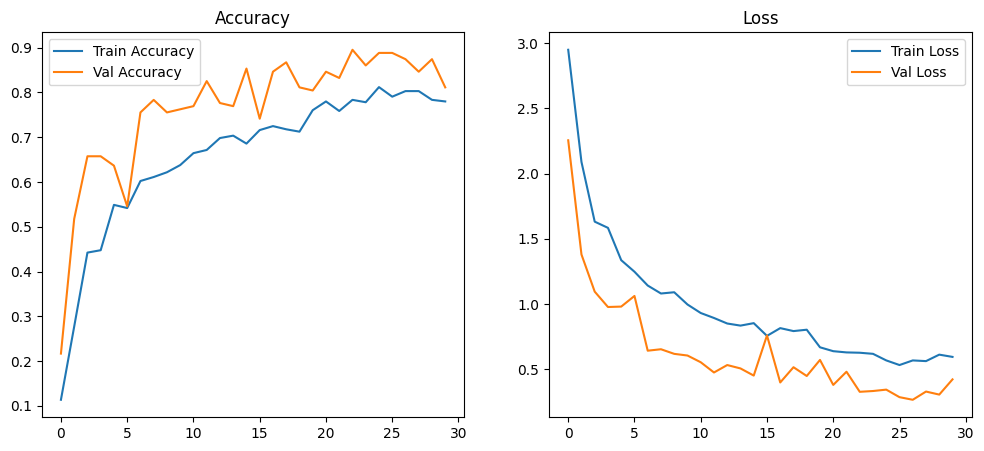

In [9]:
def plot_training_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_training_history(history)


In [10]:
zscdtest_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step
              precision    recall  f1-score   support

      Leaf 0       0.75      0.32      0.44        19
      Leaf 1       1.00      1.00      1.00        19
     Leaf 10       0.89      0.89      0.89        19
     Leaf 11       0.86      1.00      0.93        19
     Leaf 12       1.00      1.00      1.00        19
     Leaf 13       1.00      1.00      1.00        19
     Leaf 14       1.00      1.00      1.00        19
      Leaf 2       0.56      0.95      0.71        19
      Leaf 3       1.00      1.00      1.00        19
      Leaf 4       1.00      1.00      1.00        19
      Leaf 5       0.93      0.74      0.82        19
      Leaf 6       1.00      1.00      1.00        19
      Leaf 7       1.00      0.84      0.91        19
      Leaf 8       0.86      0.95      0.90        19
      Leaf 9       1.00      1.00      1.00        19

    accuracy                           0.91       285
   macro avg       0.92      0.91      0.

In [11]:
# Evaluate test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.8496 - loss: 0.2744
Test Accuracy: 87.41%
Test Loss: 0.2659


In [12]:
# Predict class indices
test_gen.reset()
y_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step
              precision    recall  f1-score   support

      Leaf 0       0.75      0.32      0.44        19
      Leaf 1       1.00      1.00      1.00        19
     Leaf 10       0.89      0.89      0.89        19
     Leaf 11       0.86      1.00      0.93        19
     Leaf 12       1.00      1.00      1.00        19
     Leaf 13       1.00      1.00      1.00        19
     Leaf 14       1.00      1.00      1.00        19
      Leaf 2       0.56      0.95      0.71        19
      Leaf 3       1.00      1.00      1.00        19
      Leaf 4       1.00      1.00      1.00        19
      Leaf 5       0.93      0.74      0.82        19
      Leaf 6       1.00      1.00      1.00        19
      Leaf 7       1.00      0.84      0.91        19
      Leaf 8       0.86      0.95      0.90        19
      Leaf 9       1.00      1.00      1.00        19

    accuracy                           0.91       285
   macro avg       0.92      0.91      0.

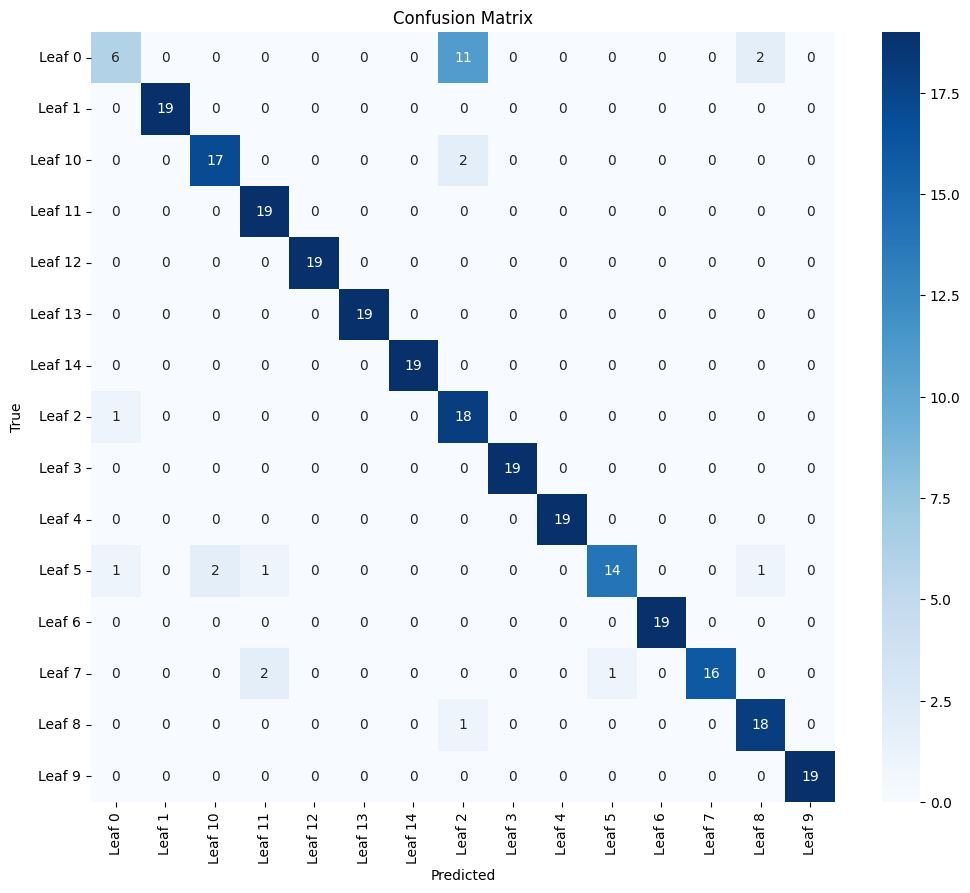

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


W0000 00:00:1744820874.267448      31 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "VALID" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 224 } dim { size: 224 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multi

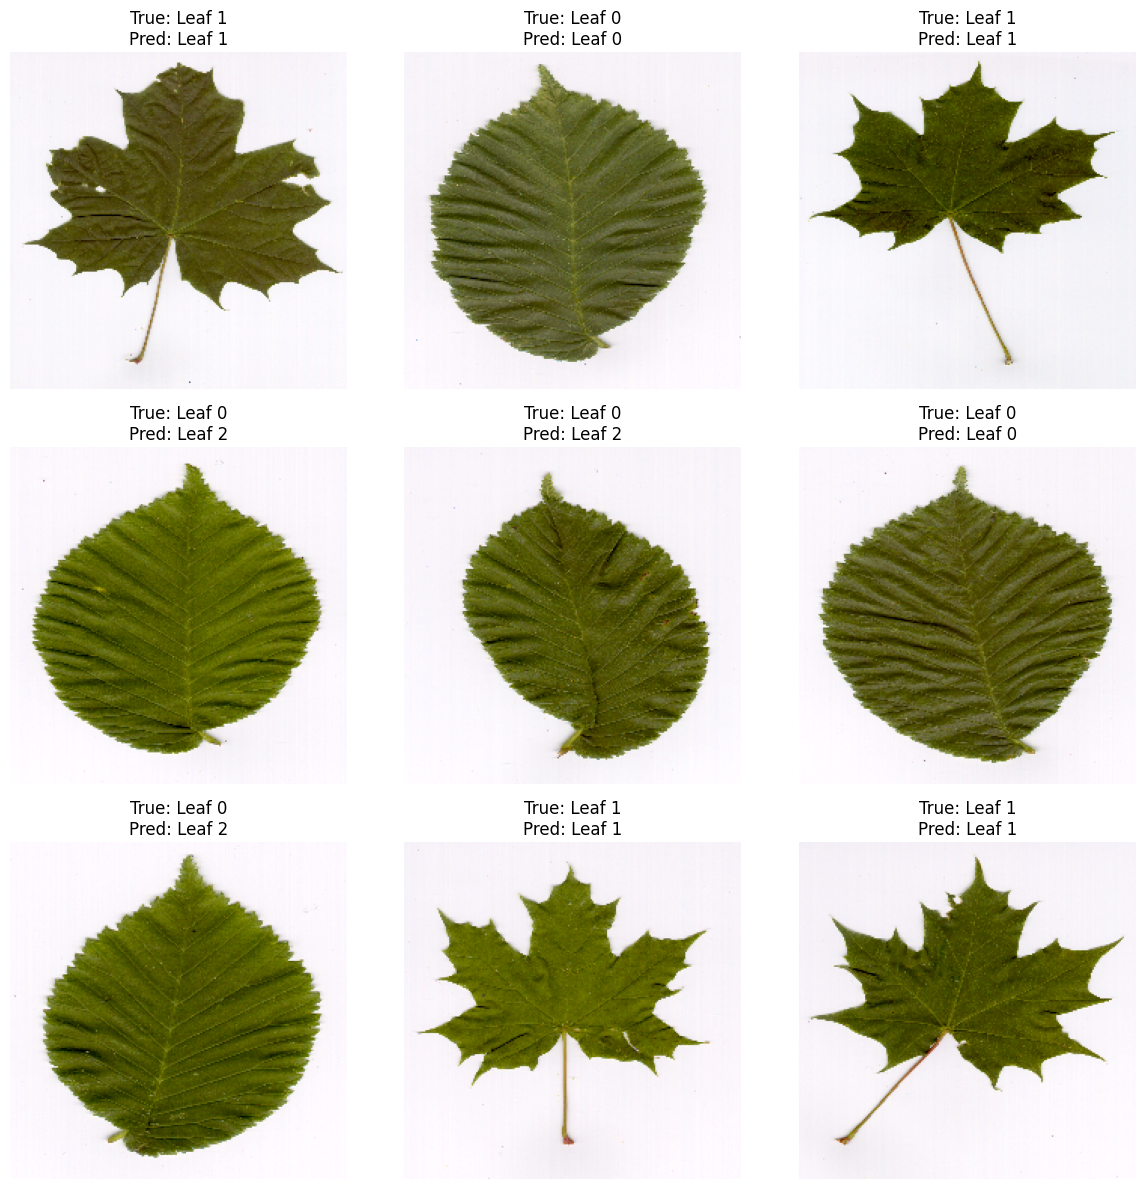

In [14]:
# Visualize 9 test images with predictions
import random
from tensorflow.keras.preprocessing import image

test_images, test_labels = next(test_gen)

plt.figure(figsize=(12, 12))
for i in range(9):
    idx = random.randint(0, len(test_images) - 1)
    img = test_images[idx]
    true_label = np.argmax(test_labels[idx])
    pred_label = np.argmax(model.predict(tf.expand_dims(img, axis=0), verbose=0))

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
plt.tight_layout()
plt.show()


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,512,687 (127.84 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,341,792 (85.23 MB)

In [16]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")


In [23]:
from tensorflow.keras.models import load_model, Model

model = load_model("best_model.keras")
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       1.00      1.00      1.00        19
           2       0.95      1.00      0.97        19
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        19
           7       0.89      0.84      0.86        19
           8       1.00      1.00      1.00        19
           9       1.00      0.95      0.97        19
          10       0.95      0.95      0.95        19
          11       1.00      1.00      1.00        19
          12       1.00      0.95      0.97        19
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        19

    accuracy                           0.97       285
 

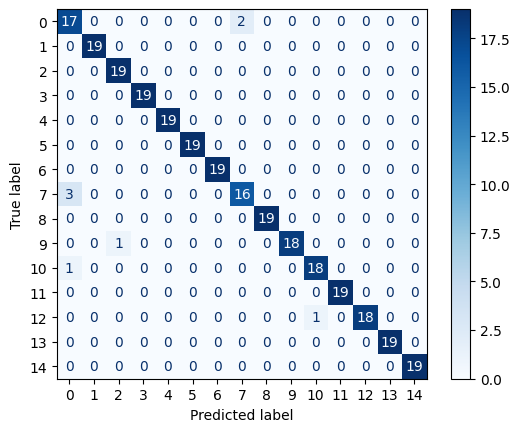

In [32]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = load_model("best_model.keras")
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

def load_images_from_directory(directory, image_size=(224, 224)):
    features = []
    labels = []
    class_names = sorted(os.listdir(directory))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(".jpg"):
                fpath = os.path.join(class_dir, fname)
                try:
                    img = load_img(fpath, target_size=image_size)
                    img_array = img_to_array(img) / 255.0
                    features.append(img_array)
                    labels.append(label_map[class_name])
                except Exception as e:
                    print(f"Skipped: {fpath} - {e}")
    
    return np.array(features), np.array(labels)

X_test_raw, y_test = load_images_from_directory("/kaggle/input/swedish-leaf-dataset/Swedish/Test", image_size=(224, 224))
X_test_features = feature_extractor.predict(X_test_raw, batch_size=32, verbose=1)

X_train_raw, y_train = load_images_from_directory("/kaggle/input/swedish-leaf-dataset/Swedish/Train", image_size=(224, 224))
X_train_features = feature_extractor.predict(X_train_raw, batch_size=32, verbose=1)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_features, y_train)

y_pred = knn.predict(X_test_features)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


Test Accuracy: 97.19%


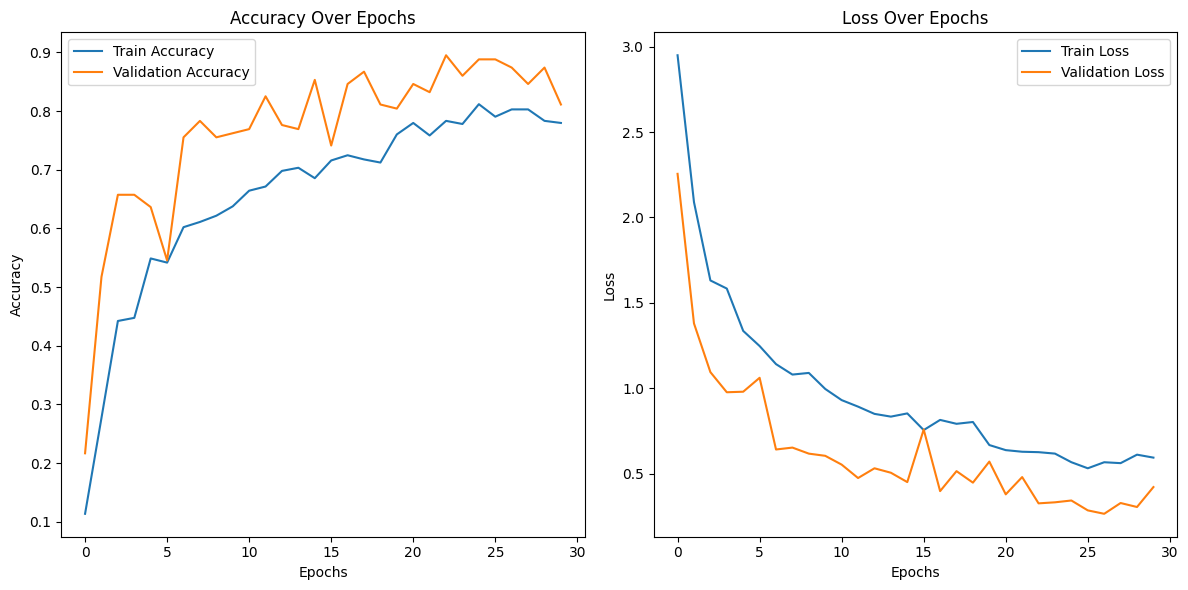

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        19
           7       0.94      0.84      0.89        19
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        19
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        19

    accuracy                           0.99       285
  

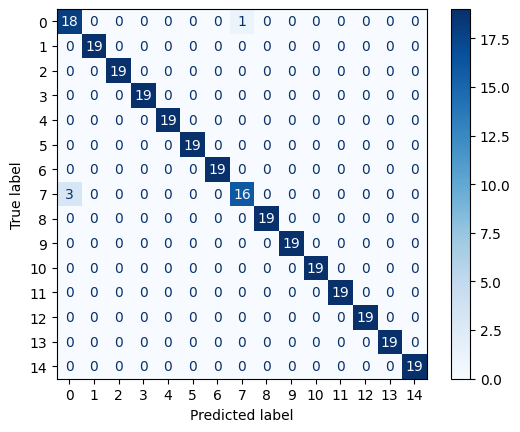

In [34]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = load_model("best_model.keras")
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

def load_images_from_directory(directory, image_size=(224, 224)):
    features = []
    labels = []
    class_names = sorted(os.listdir(directory))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(".jpg"):
                fpath = os.path.join(class_dir, fname)
                try:
                    img = load_img(fpath, target_size=image_size)
                    img_array = img_to_array(img) / 255.0
                    features.append(img_array)
                    labels.append(label_map[class_name])
                except Exception as e:
                    print(f"Skipped: {fpath} - {e}")
    
    return np.array(features), np.array(labels)

X_test_raw, y_test = load_images_from_directory("/kaggle/input/swedish-leaf-dataset/Swedish/Test", image_size=(224, 224))
X_test_features = feature_extractor.predict(X_test_raw, batch_size=32, verbose=1)

X_train_raw, y_train = load_images_from_directory("/kaggle/input/swedish-leaf-dataset/Swedish/Train", image_size=(224, 224))
X_train_features = feature_extractor.predict(X_train_raw, batch_size=32, verbose=1)

svm = SVC(kernel='linear')
svm.fit(X_train_features, y_train)

y_pred = svm.predict(X_test_features)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


Test Accuracy: 98.60%


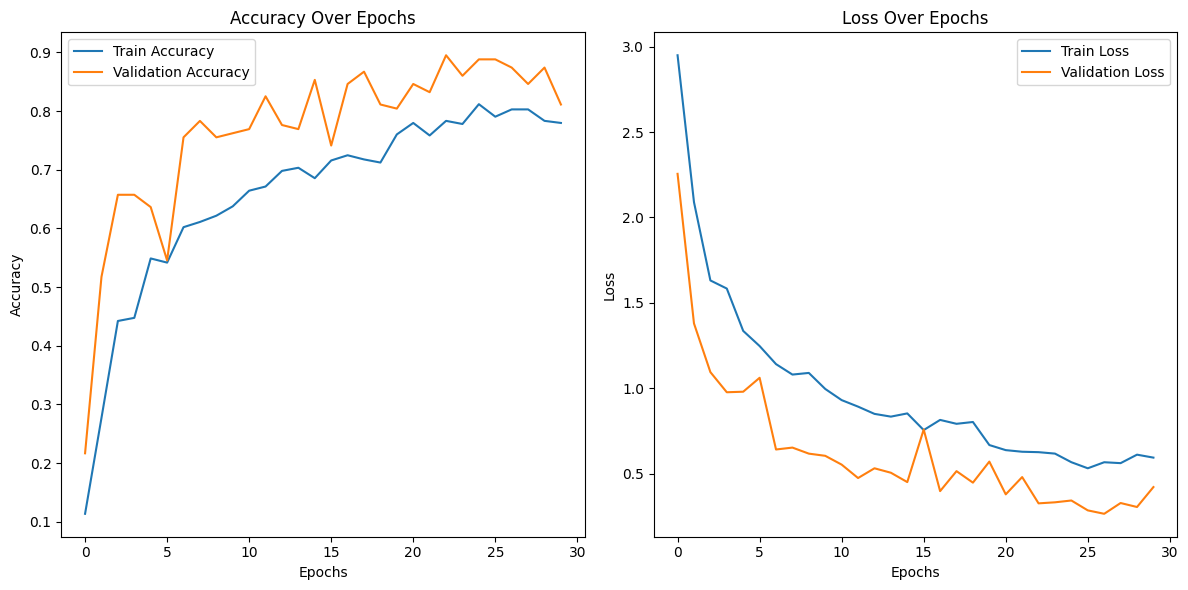

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


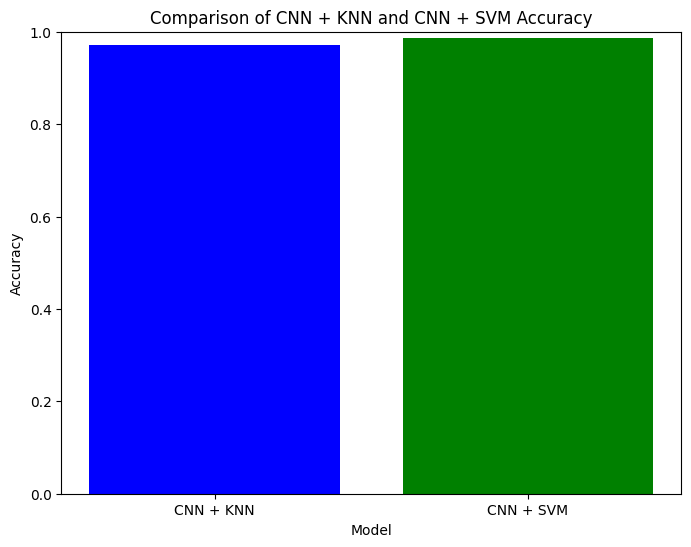

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_pred_knn = knn.predict(X_test_features)
y_pred_svm = svm.predict(X_test_features)

knn_accuracy = accuracy_score(y_test, y_pred_knn)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

models = ['CNN + KNN', 'CNN + SVM']
accuracies = [knn_accuracy, svm_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Comparison of CNN + KNN and CNN + SVM Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
